In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa một khối phần dư (Residual Block)

In [33]:



class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_1x1conv=False):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if use_1x1conv or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


In [34]:
class SmallResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallResNet, self).__init__()
        # Tầng tích chập đầu tiên
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Các khối phần dư
        self.layer1 = self._make_layer(64, 64, num_residuals=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_residuals=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_residuals=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_residuals=2, stride=2)

        # Tầng fully connected cuối cùng
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_residuals, stride):
        layers = []
        layers.append(Residual(in_channels, out_channels, stride, use_1x1conv=True))
        for _ in range(1, num_residuals):
            layers.append(Residual(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [35]:
# Chuẩn bị dữ liệu Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Hàm đánh giá mô hình và vẽ biểu đồ Loss , Acc

In [36]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy


# Hàm vẽ biểu đồ loss và accuracy
def plot_metrics(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

In [22]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Đánh giá trên test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

        # Lưu lại giá trị loss và accuracy
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Vẽ biểu đồ loss và accuracy
    plot_metrics(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)


# Train

Epoch [1/5], Train Loss: 0.0958, Train Accuracy: 96.33%, Test Loss: 0.2901, Test Accuracy: 91.60%
Epoch [2/5], Train Loss: 0.0972, Train Accuracy: 96.30%, Test Loss: 0.2975, Test Accuracy: 91.42%
Epoch [3/5], Train Loss: 0.0819, Train Accuracy: 96.89%, Test Loss: 0.3267, Test Accuracy: 91.23%
Epoch [4/5], Train Loss: 0.0757, Train Accuracy: 97.12%, Test Loss: 0.3279, Test Accuracy: 91.61%
Epoch [5/5], Train Loss: 0.0679, Train Accuracy: 97.39%, Test Loss: 0.3236, Test Accuracy: 91.16%


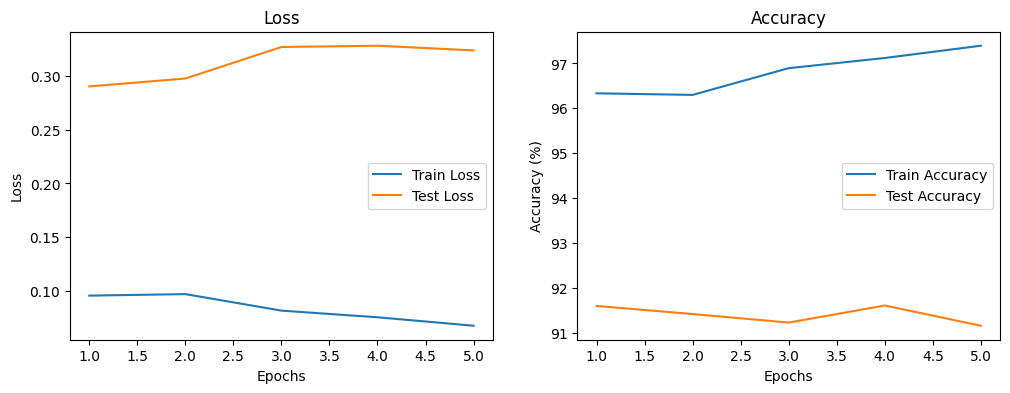

In [37]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

# Dự đoán 1 ảnh

In [38]:
def predict_single_image(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Thêm batch dimension và đưa ảnh lên device
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Chạy thử dự đoán với 1 ảnh
def test_single_image(model, testset, index=0):
    image, label = testset[index]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Ground Truth: {label}')
    plt.show()

    predicted_label = predict_single_image(model, image)
    print(f'Predicted Label: {predicted_label}')

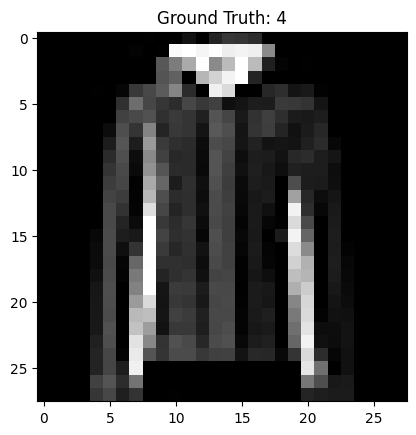

Predicted Label: 4


In [39]:
test_single_image(model, test_dataset, index=6)